In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 
import seaborn as sns


1) Importing all 7 tables from Postgres into dataframes

In [24]:
from sqlalchemy import create_engine, inspect

# PostgreSQL credentials
DB_HOST = "localhost"  
DB_PORT = "5432"
DB_NAME = "truck_data_db"
DB_USER = "postgres"
DB_PASSWORD = "saibaba"

# Create engine for PostgreSQL connection
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

# Use SQLAlchemy Inspector to get table names dynamically
inspector = inspect(engine)
tables = inspector.get_table_names()

# Dictionary to store DataFrames
dataframes = {}

# Load each table into a pandas DataFrame
for table in tables:
    # Use pandas to read the table into a DataFrame
    dataframes[table] = pd.read_sql_table(table, con=engine)

    print(f"Exported {table} ")

Exported city_weather 
Exported drivers_table 
Exported routes_table 
Exported routes_weather 
Exported traffic_table 
Exported truck_schedule_table 
Exported trucks_table 


In [25]:
for table_name in dataframes.keys(): #prints all table names
    print(table_name)


city_weather
drivers_table
routes_table
routes_weather
traffic_table
truck_schedule_table
trucks_table


In [26]:
print(dataframes['routes_table'].head())

     route_id   origin_id destination_id  distance  average_hours
0  R-ada2a391  C-927ceb5e     C-56e39a5e   1735.06          34.70
1  R-ae0ef31f  C-927ceb5e     C-73ae5412   1498.24          29.96
2  R-4beec5fd  C-927ceb5e     C-4fe0fa24   6078.46         121.57
3  R-8d7a7fb2  C-927ceb5e     C-451776b7   1543.01          30.86
4  R-b236e347  C-927ceb5e     C-d80a1e7d    310.75           6.22


In [27]:
routes_table = dataframes["routes_table"]
routes_weather = dataframes["routes_weather"]
traffic_table =dataframes["traffic_table"]
truck_schedule_table=dataframes["truck_schedule_table"]
city_weather= dataframes["city_weather"]
trucks_table=dataframes["trucks_table"]
drivers_table=dataframes["drivers_table"]

print(routes_table.columns)
print(routes_weather.columns)


Index(['route_id', 'origin_id', 'destination_id', 'distance', 'average_hours'], dtype='object')
Index(['route_id', 'Date', 'temp', 'wind_speed', 'description', 'precip',
       'humidity', 'visibility', 'pressure', 'chanceofrain', 'chanceoffog',
       'chanceofsnow', 'chanceofthunder'],
      dtype='object')


Cleaning

In [28]:
routes_table.describe()


,distance,average_hours
count,2352.000000,2352.000000
mean,2376.825230,47.536556
std,2696.904248,53.938045
min,3.900000,0.080000
25%,557.365000,11.147500
50%,1104.825000,22.100000
75%,2516.407500,50.327500
max,10055.010000,201.100000


In [29]:
routes_table.isnull().sum()

route_id          0
origin_id         0
destination_id    0
distance          0
average_hours     0
dtype: int64

Combine the tables

In [30]:

# Merge the DataFrames on the 'routes_id' column
combined_df = pd.merge(routes_table, routes_weather, on="route_id", how="inner")

# Display the combined DataFrame
print(combined_df.head(1))

     route_id   origin_id destination_id  distance  average_hours  \
0  R-ada2a391  C-927ceb5e     C-56e39a5e   1735.06           34.7   

                  Date  temp  wind_speed description  precip  humidity  \
0  2019-01-01 00:00:00    30          11  Heavy snow     0.0        90   

   visibility  pressure  chanceofrain  chanceoffog  chanceofsnow  \
0           1      1010             0            0             0   

   chanceofthunder  
0                0  


In [31]:
subset_data = combined_df.head(100000)


In [32]:
print(combined_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425712 entries, 0 to 425711
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   route_id         425712 non-null  object 
 1   origin_id        425712 non-null  object 
 2   destination_id   425712 non-null  object 
 3   distance         425712 non-null  float64
 4   average_hours    425712 non-null  float64
 5   Date             425712 non-null  object 
 6   temp             425712 non-null  int64  
 7   wind_speed       425712 non-null  int64  
 8   description      425712 non-null  object 
 9   precip           425712 non-null  float64
 10  humidity         425712 non-null  int64  
 11  visibility       425712 non-null  int64  
 12  pressure         425712 non-null  int64  
 13  chanceofrain     425712 non-null  int64  
 14  chanceoffog      425712 non-null  int64  
 15  chanceofsnow     425712 non-null  int64  
 16  chanceofthunder  425712 non-null  int6

In [33]:
combined_df['temp'] = combined_df['temp'].astype('int32')
combined_df['wind_speed'] = combined_df['wind_speed'].astype('int32')
combined_df['humidity'] = combined_df['humidity'].astype('int32')
combined_df['visibility'] = combined_df['visibility'].astype('int32')
combined_df['pressure'] = combined_df['pressure'].astype('int32')
combined_df['chanceofrain'] = combined_df['chanceofrain'].astype('int16')
combined_df['chanceoffog'] = combined_df['chanceoffog'].astype('int16')
combined_df['chanceofsnow'] = combined_df['chanceofsnow'].astype('int16')
combined_df['chanceofthunder'] = combined_df['chanceofthunder'].astype('int16') #make into loop

In [34]:
def optimize_data_types(df):
    for col in df.select_dtypes(include=["int", "float"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="unsigned")
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype("category")
    return df

subset_data = optimize_data_types(subset_data)
traffic_table = optimize_data_types(traffic_table)
truck_schedule_table = optimize_data_types(truck_schedule_table)


C:\Users\sriva\AppData\Local\Temp\ipykernel_32328\4045413141.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], downcast="unsigned")
C:\Users\sriva\AppData\Local\Temp\ipykernel_32328\4045413141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("category")
C:\Users\sriva\AppData\Local\Temp\ipykernel_32328\4045413141.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [35]:
# Step 2: Merge traffic data
subset_data = pd.merge(subset_data, traffic_table, on="route_id", how="left")

# Step 3: Merge truck schedule
subset_data = pd.merge(subset_data, truck_schedule_table, on="route_id", how="inner")
del traffic_table  # Free up memory
del truck_schedule_table  # Free up memory



KeyboardInterrupt: 

In [ ]:
print(combined_df.head(1))

In [ ]:

# Step 4: Add city weather (matching origin_id and destination_id with city_id)
combined_df = pd.merge(
    combined_df, city_weather, left_on="origin_id", right_on="city_id", how="left"
)
combined_df = pd.merge(
    combined_df, city_weather, left_on="destination_id", right_on="city_id", suffixes=("_origin", "_destination"), how="left"
)

# Step 5: Merge truck and driver data
combined_df = pd.merge(combined_df, trucks_table, left_on="truck_id", right_on="truck_id", how="left")
combined_df = pd.merge(combined_df, drivers_table, left_on="truck_id", right_on="vehicle_no", how="left")


In [ ]:
def perform_eda(df, table_name):
    print(f"\n--- EDA for {table_name} ---")
    print("\n1. First 5 Rows:")
    print(df.head())

    print("\n2. DataFrame Shape:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\n3. Column Data Types:")
    print(df.dtypes)

    print("\n4. Null Values:")
    print(df.isnull().sum())

    print("\n5. Duplicate Records:")
    print(df.duplicated().sum())

    print("\n6. Summary Statistics (Numerical):")
    print(df.describe())

    print("\n7. Unique Values per Column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} unique values")



In [ ]:
perform_eda(routes_table, "Routes Table")
perform_eda(routes_weather, "Routes Weather")
perform_eda(traffic_table, "Traffic Table")
perform_eda(truck_schedule_table, "Truck Schedule Table")
perform_eda(city_weather, "City Weather")
perform_eda(drivers_table, "Drivers Table")
perform_eda(trucks_table, "Trucks Table")



--- EDA for Routes Table ---

1. First 5 Rows:
     route_id   origin_id destination_id  distance  average_hours
0  R-ada2a391  C-927ceb5e     C-56e39a5e   1735.06          34.70
1  R-ae0ef31f  C-927ceb5e     C-73ae5412   1498.24          29.96
2  R-4beec5fd  C-927ceb5e     C-4fe0fa24   6078.46         121.57
3  R-8d7a7fb2  C-927ceb5e     C-451776b7   1543.01          30.86
4  R-b236e347  C-927ceb5e     C-d80a1e7d    310.75           6.22

2. DataFrame Shape:
Rows: 2352, Columns: 5

3. Column Data Types:
route_id           object
origin_id          object
destination_id     object
distance          float64
average_hours     float64
dtype: object

4. Null Values:
route_id          0
origin_id         0
destination_id    0
distance          0
average_hours     0
dtype: int64

5. Duplicate Records:
0

6. Summary Statistics (Numerical):
           distance  average_hours
count   2352.000000    2352.000000
mean    2376.825230      47.536556
std     2696.904248      53.938045
min        3.9

In [ ]:
import seaborn as sns
numeric_df = routes_weather.drop(columns=['route_id'])

# Perform correlation or analysis
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


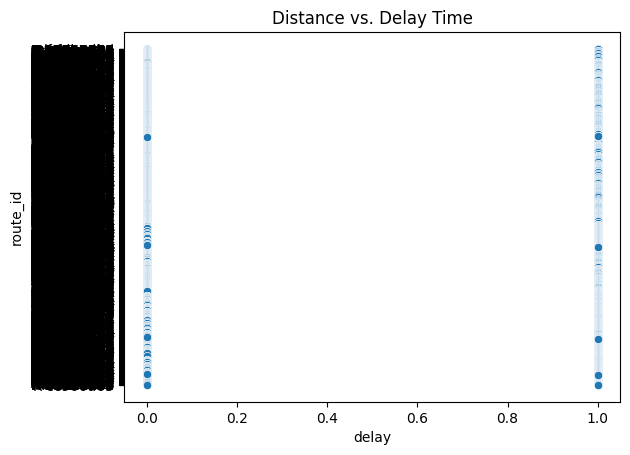

In [ ]:
sns.scatterplot(x=truck_schedule_table['delay'], y=truck_schedule_table['route_id'])
plt.title("Distance vs. Delay Time")
plt.show()


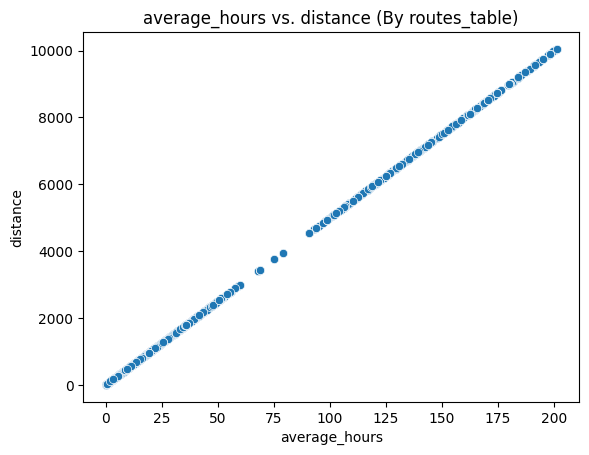

In [ ]:
sns.scatterplot(x=routes_table['average_hours'], 
                y=routes_table['distance'], 
                )
plt.title("average_hours vs. distance (By routes_table)")
plt.show()


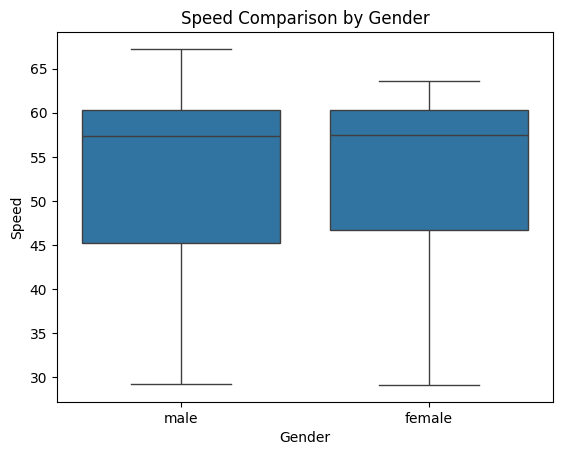

In [ ]:
sns.boxplot(x=drivers_table['gender'], y=drivers_table['average_speed_mph'])
plt.title("Speed Comparison by Gender")
plt.xlabel("Gender")
plt.ylabel("Speed")
plt.show()


C:\Users\sriva\AppData\Local\Temp\ipykernel_12796\4289166218.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x=drivers_table['driving_style'], y=drivers_table['average_speed_mph'], jitter=True, palette="pastel")


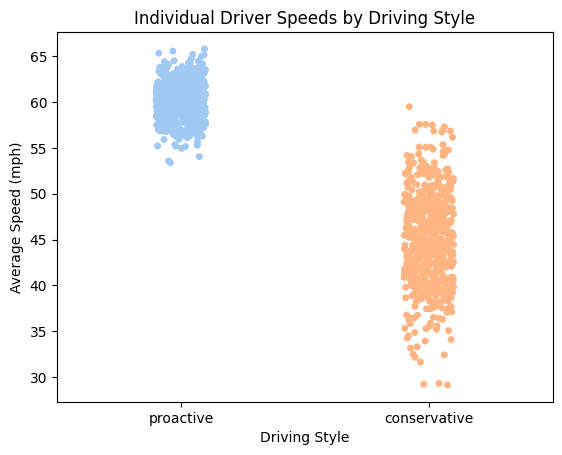

In [ ]:
sns.stripplot(x=drivers_table['driving_style'], y=drivers_table['average_speed_mph'], jitter=True, palette="pastel")
plt.title("Individual Driver Speeds by Driving Style")
plt.xlabel("Driving Style")
plt.ylabel("Average Speed (mph)")
plt.show()


In [37]:
merged_data = pd.merge(traffic_table, truck_schedule_table, on="route_id", how="inner")

# Step 2: Basic Inspection
print(merged_data.info())  # Check data types and missing values
print(merged_data.describe())  # Summary statistics


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13595501 entries, 0 to 13595500
Data columns (total 9 columns):
 #   Column             Dtype   
---  ------             -----   
 0   route_id           category
 1   date               category
 2   hour               uint16  
 3   no_of_vehicles     float64 
 4   accident           uint8   
 5   truck_id           uint32  
 6   departure_date     category
 7   estimated_arrival  category
 8   delay              uint8   
dtypes: category(4), float64(1), uint16(1), uint32(1), uint8(2)
memory usage: 285.6 MB
None
               hour  no_of_vehicles      accident      truck_id         delay
count  1.359550e+07    1.359310e+07  1.359550e+07  1.359550e+07  1.359550e+07
mean   1.150026e+03    1.545146e+03  5.364400e-02  3.291021e+07  3.488310e-01
std    6.922229e+02    9.040391e+02  2.253138e-01  2.221208e+07  4.766004e-01
min    0.000000e+00    1.000000e+02  0.000000e+00  1.000839e+07  0.000000e+00
25%    6.000000e+02    6.000000e+02  0.00

In [39]:
categorical_columns = ['route_id', 'date', 'departure_date', 'estimated_arrival']
merged_data[categorical_columns] = merged_data[categorical_columns].astype('category')

# Data Inspection
print(merged_data.info())  # Verify data types
print(merged_data.describe())  # Summary of numeric columns

# Handle Missing Values
# Check for missing values
print(merged_data.isnull().sum())
# Fill missing numerical columns with median
merged_data.fillna(merged_data.median(numeric_only=True), inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13595501 entries, 0 to 13595500
Data columns (total 9 columns):
 #   Column             Dtype   
---  ------             -----   
 0   route_id           category
 1   date               category
 2   hour               uint16  
 3   no_of_vehicles     float64 
 4   accident           uint8   
 5   truck_id           uint32  
 6   departure_date     category
 7   estimated_arrival  category
 8   delay              uint8   
dtypes: category(4), float64(1), uint16(1), uint32(1), uint8(2)
memory usage: 285.6 MB
None
               hour  no_of_vehicles      accident      truck_id         delay
count  1.359550e+07    1.359310e+07  1.359550e+07  1.359550e+07  1.359550e+07
mean   1.150026e+03    1.545146e+03  5.364400e-02  3.291021e+07  3.488310e-01
std    6.922229e+02    9.040391e+02  2.253138e-01  2.221208e+07  4.766004e-01
min    0.000000e+00    1.000000e+02  0.000000e+00  1.000839e+07  0.000000e+00
25%    6.000000e+02    6.000000e+02  0.00

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='accident', y='delay')
plt.title("Impact of Accidents on Delay")
plt.xlabel("Accident (1=Yes, 0=No)")
plt.ylabel("Delay (minutes)")
plt.show()


In [ ]:
# Scatterplot: Hour vs. Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='hour', y='delay', hue='accident', palette="cool")
plt.title("Hour of Day vs. Delay")
plt.xlabel("Hour")
plt.ylabel("Delay (minutes)")
plt.show()


KeyboardInterrupt: 

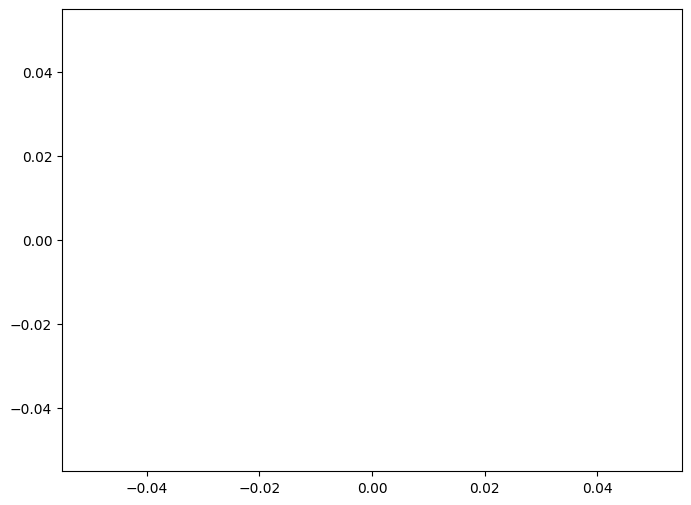

In [42]:

plt.figure(figsize=(8, 6))
sns.histplot(merged_data['delay'], bins=20, kde=True)
plt.title("Delay Distribution")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.show()


1) redo this cleaner
2) this time reduce the rows
3) delete useless features